In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import os
import pickle
from tqdm import tqdm
from pylab import rcParams
from torch import nn, optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [2]:
# 폰트 설정 (Windows: Malgun Gothic, Mac: AppleGothic, Linux: 나눔고딕 등)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv(r'C:\Users\CITYEYELAB5\Desktop\interpol\pre_df_교차로1558.csv')

In [4]:
df = df.drop(columns=['weekday'])
train_df = df[df['month'].isin([3,5,9])]
test_df = df[df['month'] == 11]

df_train = train_df.copy()
df_test = test_df.copy()

In [5]:
# 입력값만 스케일링
input_features = ['month', 'day', 'hour_decimal', 'latitude', 'longitude']

scaler_X = StandardScaler()

# 훈련 데이터와 테스트 데이터 입력값 스케일링
df_train[input_features] = scaler_X.fit_transform(df_train[input_features])
df_test[input_features] = scaler_X.transform(df_test[input_features])

# 타겟값 스케일링
scaler_y = StandardScaler()

# 타겟값 스케일링
df_train['traffic_volume'] = scaler_y.fit_transform(df_train[['traffic_volume']])
df_test['traffic_volume'] = scaler_y.transform(df_test[['traffic_volume']])

In [6]:
train_features = ['month','day', 'hour_decimal', 'latitude', 'longitude',
            'vehicle_대형', 'vehicle_소형', 'dir_1', 'dir_2', 'dir_3', 'dir_4', 'dir_5',
       'dir_6', 'dir_7', 'dir_8', 'dir_9', 'dir_10', 'dir_11', 'dir_12']
train_target = ['traffic_volume']

test_features = ['month','day', 'hour_decimal', 'latitude', 'longitude',
            'vehicle_대형', 'vehicle_소형', 'dir_1', 'dir_2', 'dir_3', 'dir_4', 'dir_5',
       'dir_6', 'dir_7', 'dir_8', 'dir_9', 'dir_10', 'dir_11', 'dir_12']
test_target = ['traffic_volume']

In [7]:
def create_sequences_by_intersection(df, seq_length, features, target):
    sequences = []
    targets = []
    
    # 교차로별로 그룹화
    grouped_intersections = df.groupby('교차로명')
    
    for intersection, group in grouped_intersections:
        # 시간대별로 그룹화
        grouped = group.groupby('datetime')
        time_groups = sorted(grouped.groups.keys())
        
        for i in range(len(time_groups) - seq_length + 1):
            sequence = []
            for j in range(seq_length):
                current_time = time_groups[i + j]
                current_data = grouped.get_group(current_time)[features].values
                mean_data = np.mean(current_data, axis=0)
                sequence.append(mean_data)
            
            target_time = time_groups[i + seq_length - 1]
            target_data = grouped.get_group(target_time)[target].values
            target_mean = np.mean(target_data)
            
            sequences.append(sequence)
            targets.append(target_mean)
    
    return np.array(sequences), np.array(targets)

In [8]:
# 훈련 데이터를 훈련셋과 검증셋으로 분할
train_size = int(len(df_train) * 0.8)  # 80%를 훈련셋으로 사용

# 데이터 분할
train_data = df_train
val_data = df_train[train_size:]  # 나머지 20%를 검증셋으로 사용
test_data = df_test  # 테스트셋은 별도의 데이터 사용

seq_length = 4

# 시퀀스 생성
X_train, y_train = create_sequences_by_intersection(train_data, seq_length, train_features, train_target)
X_val, y_val = create_sequences_by_intersection(val_data, seq_length, train_features, train_target)
X_test, y_test = create_sequences_by_intersection(test_data, seq_length, test_features, test_target)


In [9]:
def make_Tensor(array):
    return torch.from_numpy(array).float()

In [10]:
X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([690, 4, 19])
torch.Size([690])
torch.Size([120, 4, 19])
torch.Size([120])
torch.Size([210, 4, 19])
torch.Size([210])


In [12]:
batch_size = 32  # 배치 크기 설정

# TensorDataset 생성
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# DataLoader로 미니배치 구성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(1, 2))
        x = x.permute(1, 2)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual 
        
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)

        # 2) Linear layers -> [Batch, Channel, forcast_size]
        trend_output = self.Linear_Trend(trend_init)
        seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = trend_output + seasonal_output  # [Batch, Channel, forcast_size]

        x = x.permute(0,2,1) # [Batch, forcast_size, Channel]
        x = x.mean(dim=-1, keepdim=True) # [Batch, forcast_size, 1]
        return x


In [14]:
class LTSF_NLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, individual, feature_size):
        super(LTSF_NLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

    def forward(self, x):
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0), self.forcast_size, x.size(2)], dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0, 2, 1))
        x = x.squeeze(-1)  # 마지막 차원 제거
        x = x + seq_last.squeeze(1)  # seq_last의 두 번째 차원 제거
        x = x.mean(dim=-1, keepdim=True)  # 모든 특성의 평균을 계산하여 단일 값으로 축소
        return x

In [15]:
window_size = 4
forcast_size = 1

In [17]:
train_loss_list = []
valid_loss_list = []
test_loss_list = []

epochs = 200
lr = 0.001

NLinear_model = LTSF_NLinear(
    window_size=window_size,
    forcast_size=forcast_size,
    individual=False,
    feature_size=1,
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(NLinear_model.parameters(), lr=lr)

# 최초에 max_loss를 매우 큰 값으로 설정
max_loss = float('inf')

for epoch in range(1, epochs + 1):
    ############################################################################
    # 1) Training
    ############################################################################
    NLinear_model.train()
    train_losses = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = NLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))  # (batch_size, 1) 비교
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    # 이번 epoch의 평균 train loss
    train_epoch_loss = np.mean(train_losses)
    train_loss_list.append(train_epoch_loss)

    ############################################################################
    # 2) Validation
    ############################################################################
    NLinear_model.eval()
    valid_losses = []
    with torch.no_grad():
        for data, target in val_loader:
            output = NLinear_model(data)
            loss = criterion(output, target.unsqueeze(-1))
            valid_losses.append(loss.item())
    
    # 이번 epoch의 평균 valid loss
    valid_epoch_loss = np.mean(valid_losses)
    valid_loss_list.append(valid_epoch_loss)

    ############################################################################
    # 3) Test
    ############################################################################
    test_losses = []
    with torch.no_grad():
        for data, target in test_loader:
            output = NLinear_model(data)
            loss = criterion(output, target.unsqueeze(-1))
            test_losses.append(loss.item())
    
    # 이번 epoch의 평균 test loss
    test_epoch_loss = np.mean(test_losses)
    test_loss_list.append(test_epoch_loss)

    ############################################################################
    # 4) Checkpoint (모델 저장)
    ############################################################################
    # valid_epoch_loss 가 기존 max_loss보다 작으면 -> 모델 저장
    if valid_epoch_loss < max_loss:
        torch.save(NLinear_model.state_dict(), "NLinear_model.pth")
        max_loss = valid_epoch_loss
        print(
            "valid_loss={:.6f}, test_loss={:.6f}, Model Save!".format(
                valid_epoch_loss, test_epoch_loss
            )
        )
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_epoch_loss
        dlinear_best_valid_loss = valid_epoch_loss
        dlinear_best_test_loss = test_epoch_loss

    ############################################################################
    # 5) 로그 출력
    ############################################################################
    print(
        "Epoch [{}/{}], train_loss={:.6f}, valid_loss={:.6f}, test_loss={:.6f}".format(
            epoch, epochs,
            train_epoch_loss,
            valid_epoch_loss,
            test_epoch_loss
        )
    )

print("\n[Training Finished]")
print("Best model was saved at epoch = {}, valid_loss={:.6f}, test_loss={:.6f}".format(
    dlinear_best_epoch, dlinear_best_valid_loss, dlinear_best_test_loss)
)


valid_loss=0.061432, test_loss=0.105845, Model Save!
Epoch [1/200], train_loss=0.060451, valid_loss=0.061432, test_loss=0.105845
valid_loss=0.060822, test_loss=0.104041, Model Save!
Epoch [2/200], train_loss=0.059966, valid_loss=0.060822, test_loss=0.104041
valid_loss=0.060291, test_loss=0.102408, Model Save!
Epoch [3/200], train_loss=0.059645, valid_loss=0.060291, test_loss=0.102408
valid_loss=0.059839, test_loss=0.100960, Model Save!
Epoch [4/200], train_loss=0.059377, valid_loss=0.059839, test_loss=0.100960
valid_loss=0.059454, test_loss=0.099679, Model Save!
Epoch [5/200], train_loss=0.059152, valid_loss=0.059454, test_loss=0.099679
valid_loss=0.059128, test_loss=0.098546, Model Save!
Epoch [6/200], train_loss=0.058963, valid_loss=0.059128, test_loss=0.098546
valid_loss=0.058850, test_loss=0.097543, Model Save!
Epoch [7/200], train_loss=0.058801, valid_loss=0.058850, test_loss=0.097543
valid_loss=0.058613, test_loss=0.096654, Model Save!
Epoch [8/200], train_loss=0.058662, valid_lo

In [ ]:
### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 50
lr = 0.001
DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=19,
                            )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    with torch.no_grad():
        for data, target in val_loader:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)
        
        for data, target in test_loader:
            output = DLinear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

In [ ]:
train_loss_list = []
valid_loss_list = []
test_loss_list = []

epochs = 50
lr = 0.001

DLinear_model = LTSF_DLinear(
    window_size=window_size,
    forcast_size=forcast_size,
    kernel_size=25,
    individual=False,
    feature_size=19,
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)

# 최초에 max_loss를 매우 큰 값으로 설정
max_loss = float('inf')

for epoch in range(1, epochs + 1):
    ############################################################################
    # 1) Training
    ############################################################################
    DLinear_model.train()
    train_losses = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))  # (batch_size, 1) 비교
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    # 이번 epoch의 평균 train loss
    train_epoch_loss = np.mean(train_losses)
    train_loss_list.append(train_epoch_loss)

    ############################################################################
    # 2) Validation
    ############################################################################
    DLinear_model.eval()
    valid_losses = []
    with torch.no_grad():
        for data, target in val_loader:
            output = DLinear_model(data)
            loss = criterion(output, target.unsqueeze(-1))
            valid_losses.append(loss.item())
    
    # 이번 epoch의 평균 valid loss
    valid_epoch_loss = np.mean(valid_losses)
    valid_loss_list.append(valid_epoch_loss)

    ############################################################################
    # 3) Test
    ############################################################################
    test_losses = []
    with torch.no_grad():
        for data, target in test_loader:
            output = DLinear_model(data)
            loss = criterion(output, target.unsqueeze(-1))
            test_losses.append(loss.item())
    
    # 이번 epoch의 평균 test loss
    test_epoch_loss = np.mean(test_losses)
    test_loss_list.append(test_epoch_loss)

    ############################################################################
    # 4) Checkpoint (모델 저장)
    ############################################################################
    # valid_epoch_loss 가 기존 max_loss보다 작으면 -> 모델 저장
    if valid_epoch_loss < max_loss:
        torch.save(DLinear_model.state_dict(), "DLinear_model.pth")
        max_loss = valid_epoch_loss
        print(
            "valid_loss={:.6f}, test_loss={:.6f}, Model Save!".format(
                valid_epoch_loss, test_epoch_loss
            )
        )
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_epoch_loss
        dlinear_best_valid_loss = valid_epoch_loss
        dlinear_best_test_loss = test_epoch_loss

    ############################################################################
    # 5) 로그 출력
    ############################################################################
    print(
        "Epoch [{}/{}], train_loss={:.6f}, valid_loss={:.6f}, test_loss={:.6f}".format(
            epoch, epochs,
            train_epoch_loss,
            valid_epoch_loss,
            test_epoch_loss
        )
    )

print("\n[Training Finished]")
print("Best model was saved at epoch = {}, valid_loss={:.6f}, test_loss={:.6f}".format(
    dlinear_best_epoch, dlinear_best_valid_loss, dlinear_best_test_loss)
)


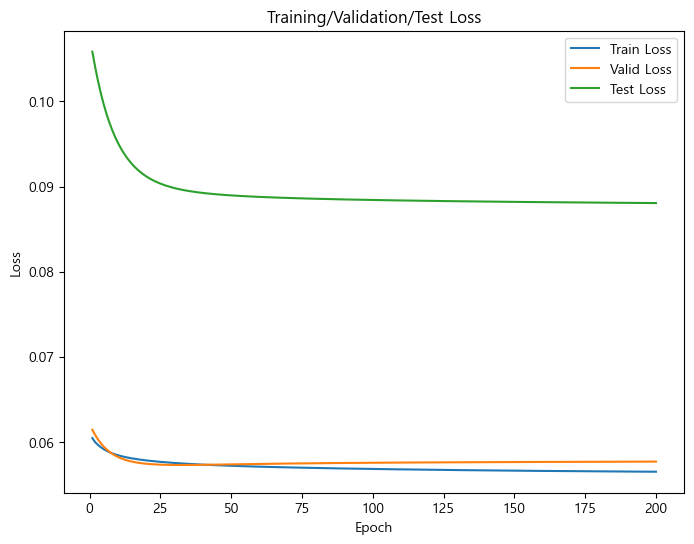

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, len(valid_loss_list) + 1), valid_loss_list, label='Valid Loss')
plt.plot(range(1, len(test_loss_list) + 1), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training/Validation/Test Loss')
plt.legend()
plt.show()

In [19]:
NLinear_model.eval()  # 모델을 평가 모드로 전환
test_loss = 0

all_preds = []  # 예측값을 모을 리스트
all_trues = []  # 실제 타겟(정답)을 모을 리스트

with torch.no_grad():  # 평가 시에는 gradient 계산 불필요
    for batch_X, batch_y in test_loader:
        # 1) 모델 예측
        outputs = NLinear_model(batch_X)

        # 2) 타겟(정답) 모양 맞추기 (예: [batch_size, 1])
        batch_y = batch_y.view(-1, 1)

        # 3) 손실(loss) 계산
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        # 4) 예측값, 실제값 저장 (나중에 시각화/분석 용)
        all_preds.append(outputs.cpu())
        all_trues.append(batch_y.cpu())

test_loss = test_loss / len(test_loader)
print("Test Loss:", test_loss)

Test Loss: 0.08806449174880981


In [20]:
# (batch-wise) 리스트 -> 하나의 텐서로 연결
all_preds_tensor = torch.cat(all_preds, dim=0)  # shape: [N, 1]
all_trues_tensor = torch.cat(all_trues, dim=0)  # shape: [N, 1]

# 텐서를 넘파이로 변환
preds = all_preds_tensor.numpy().flatten()
y_test = all_trues_tensor.numpy().flatten()

In [21]:
# preds를 numpy array로 변환 (1D -> 2D)
preds = np.array(preds).reshape(-1, 1)

# 예측값 역스케일링
y_pred_original = scaler_y.inverse_transform(preds)

# 실제값 역스케일링
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))


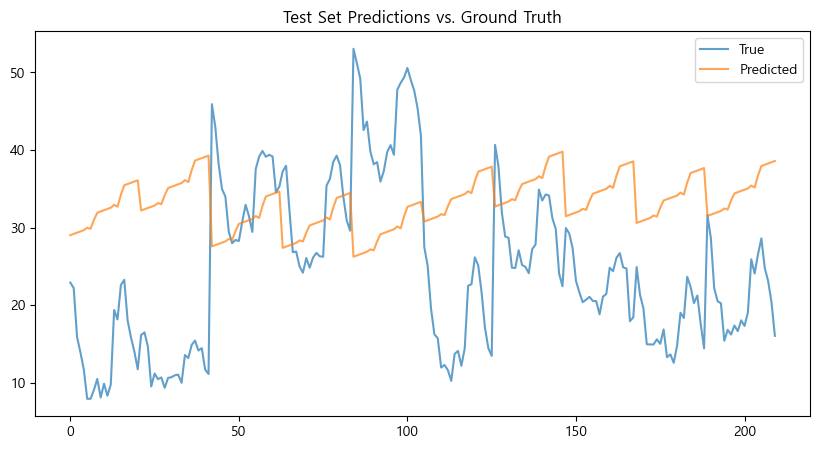

In [22]:
plt.figure(figsize=(10,5))
plt.plot(y_test_original, label='True', alpha=0.7)
plt.plot(y_pred_original, label='Predicted', alpha=0.7)
plt.legend()
plt.title('Test Set Predictions vs. Ground Truth')
plt.show()

In [23]:
# 매핑을 위해 학습에 사용된 데이터프레임과 동일한 데이터 필요
df_test['datetime'] = pd.to_datetime(df_test['datetime'])  # datetime 형식 변환
df_test = df_test.sort_values(by=['교차로명', 'datetime'])  # 교차로명과 시간으로 정렬

# 예측에 사용된 교차로별 데이터의 인덱스 추출
mapping_info = df_test[['datetime', '교차로명']].iloc[seq_length:].reset_index(drop=True)

mapping_info = mapping_info.drop_duplicates(subset=['datetime', '교차로명']).reset_index(drop=True)

unique_intersections = mapping_info['교차로명'].unique()

# 교차로의 개수
num_intersections = len(unique_intersections)

# 각 교차로에 할당할 데이터 개수
rows_per_intersection = len(y_test_original) // int(num_intersections)

In [24]:
# 결과를 저장할 리스트
results = []

# 교차로별 데이터 처리
start_idx = 0
for i, intersection in enumerate(unique_intersections):
    # 마지막 교차로는 나머지를 포함하여 할당
    if i == num_intersections - 1:
        end_idx = len(y_test_original)
    else:
        end_idx = start_idx + rows_per_intersection
    
    # 교차로별 예측값과 실제값 슬라이싱
    y_pred_intersection = y_pred_original[start_idx:end_idx]
    y_test_intersection = y_test_original[start_idx:end_idx]
    
    # 데이터가 비어 있는지 확인
    if len(y_pred_intersection) == 0 or len(y_test_intersection) == 0:
        print(f"Error: No data for {intersection}")
        continue

    # 다음 교차로로 이동
    start_idx = end_idx
    
    # 결과 저장 (딕셔너리 형태로)
    results.append({
        'intersection': intersection,
        'predicted': y_pred_intersection.flatten().tolist(),
        'actual': y_test_intersection.flatten().tolist()
    })

# 저장된 결과 확인
for result in results:
    print(f"{result['intersection']}:")
    print("Predicted:", result['predicted'])
    print("Actual:", result['actual'])

공촌3교4거리:
Predicted: [29.033361434936523, 29.194124221801758, 29.354887008666992, 29.515649795532227, 29.67641258239746, 29.989505767822266, 29.854814529418945, 31.00682258605957, 31.927095413208008, 32.08785629272461, 32.248619079589844, 32.40938186645508, 32.57014465332031, 32.94417190551758, 32.69129943847656, 34.239803314208984, 35.4638786315918, 35.6246452331543, 35.78540802001953, 35.946170806884766, 36.10693359375]
Actual: [22.91666603088379, 22.22222137451172, 15.88888931274414, 13.916666984558105, 11.722223281860352, 7.944443225860596, 7.944443225860596, 9.083333015441895, 10.5, 8.111111640930176, 9.888888359069824, 8.333333015441895, 9.777778625488281, 19.38888931274414, 18.16666603088379, 22.61111068725586, 23.27777862548828, 18.02777862548828, 15.833333969116211, 14.027777671813965, 11.750000953674316]
봉수교3거리:
Predicted: [32.213409423828125, 32.37417221069336, 32.534934997558594, 32.69569778442383, 32.85646057128906, 33.1695556640625, 33.03486251831055, 34.18687057495117, 35

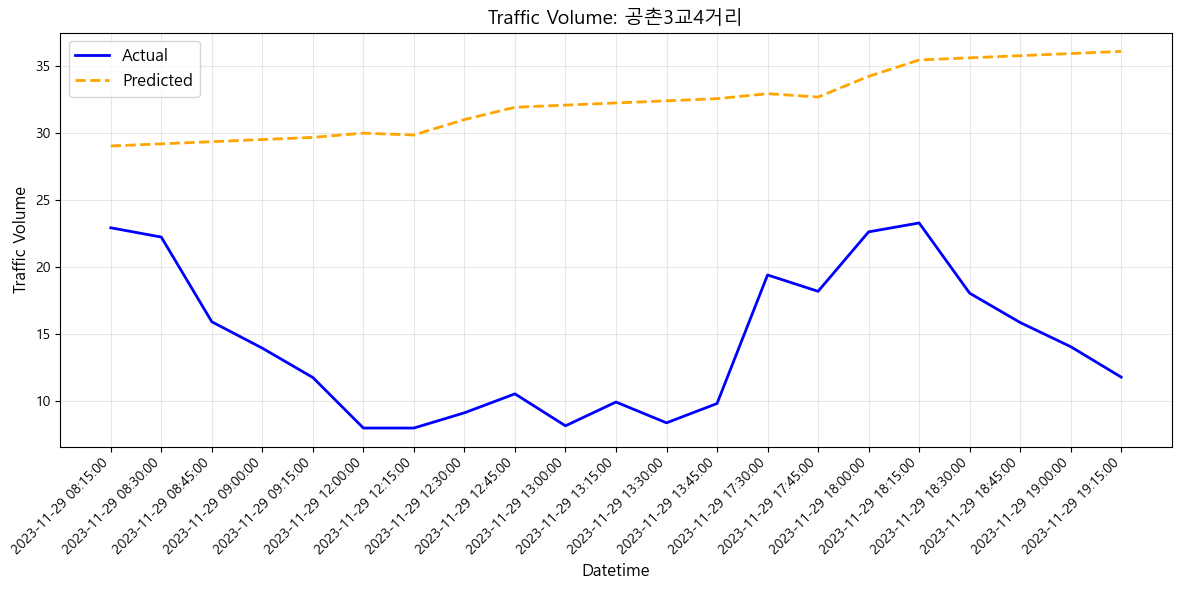

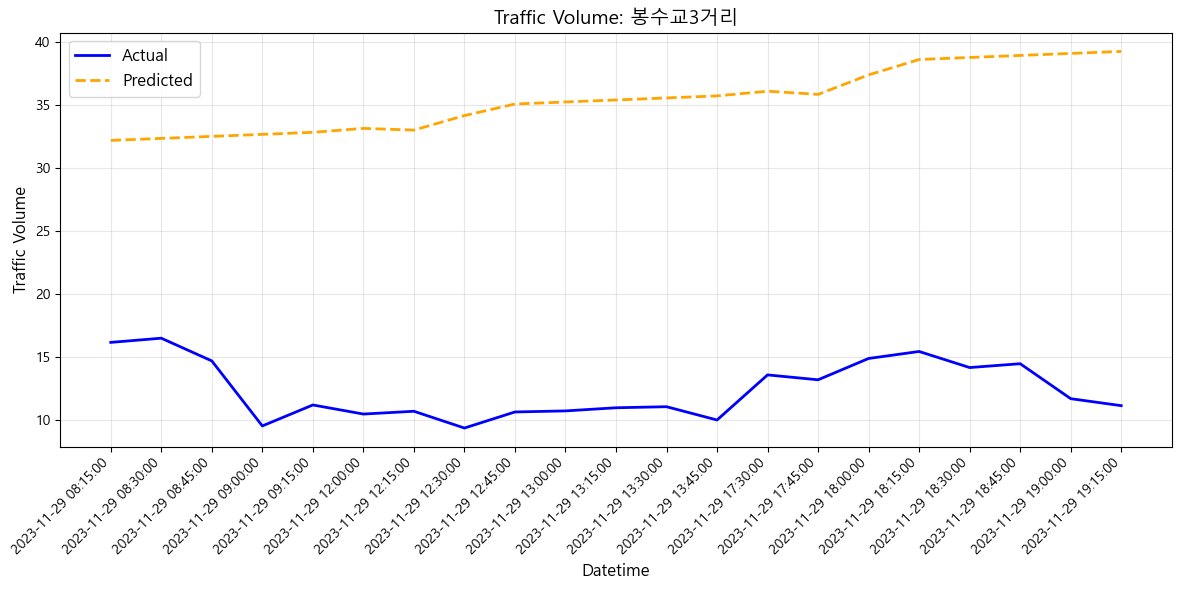

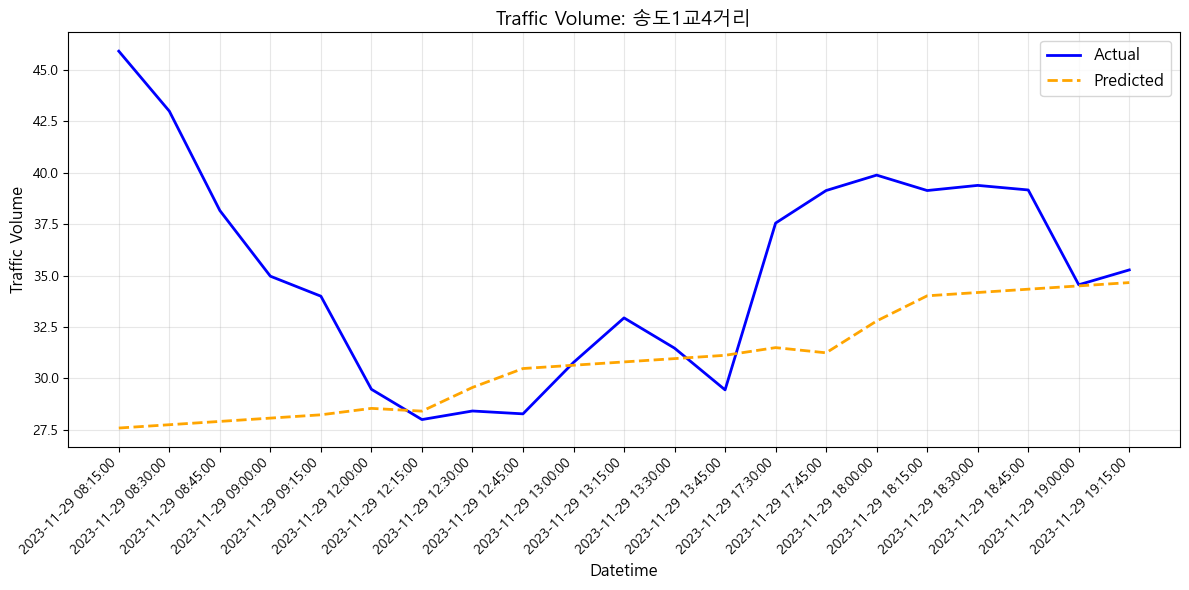

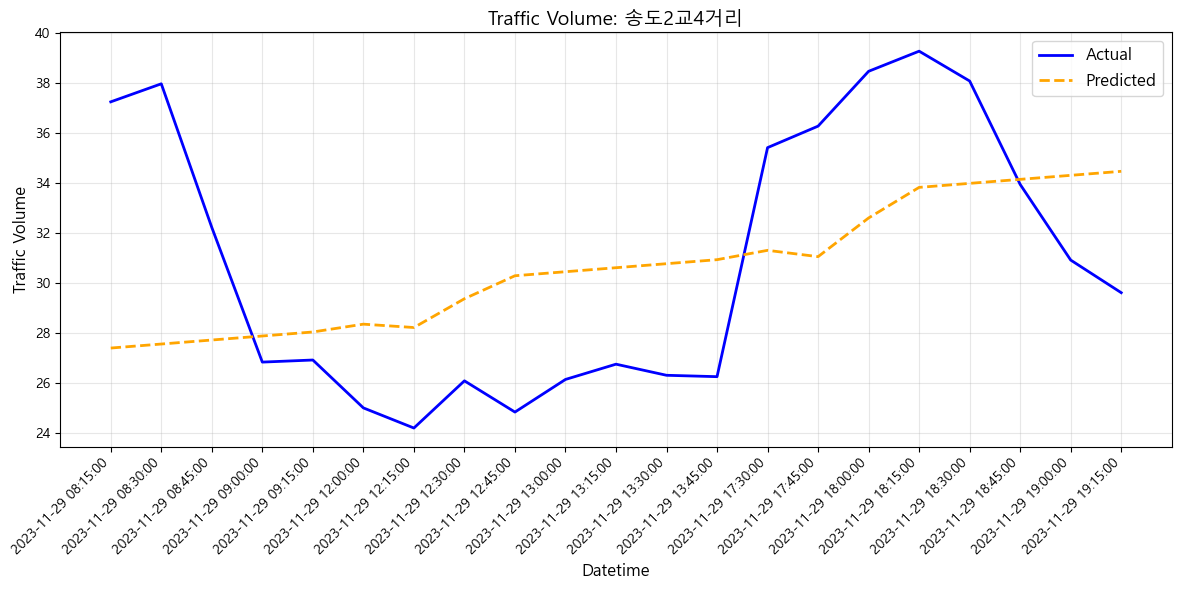

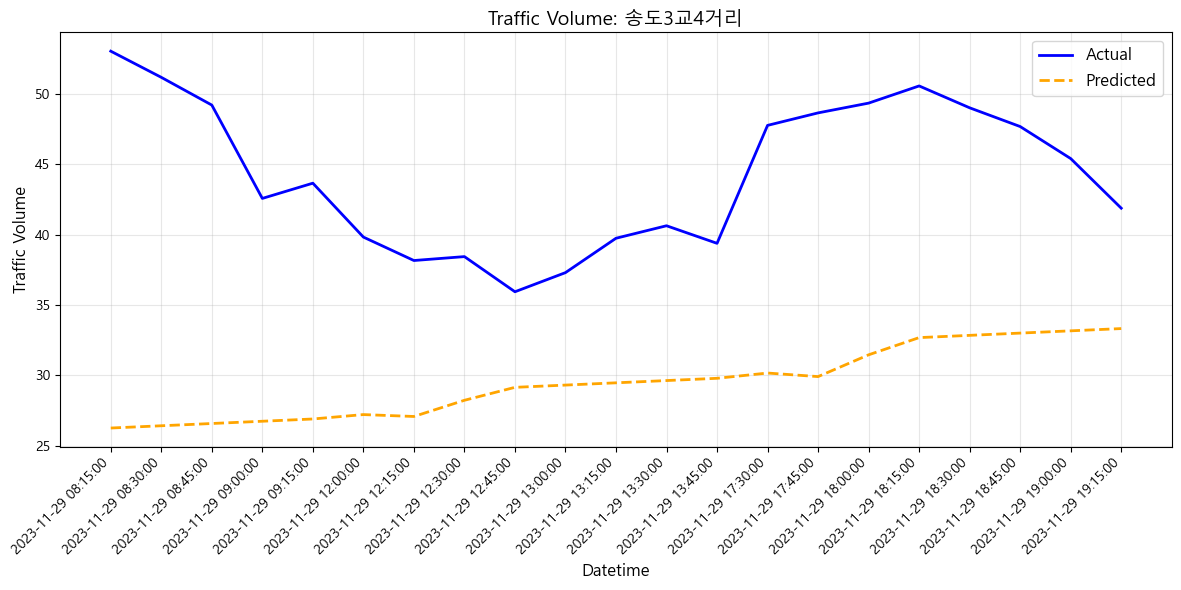

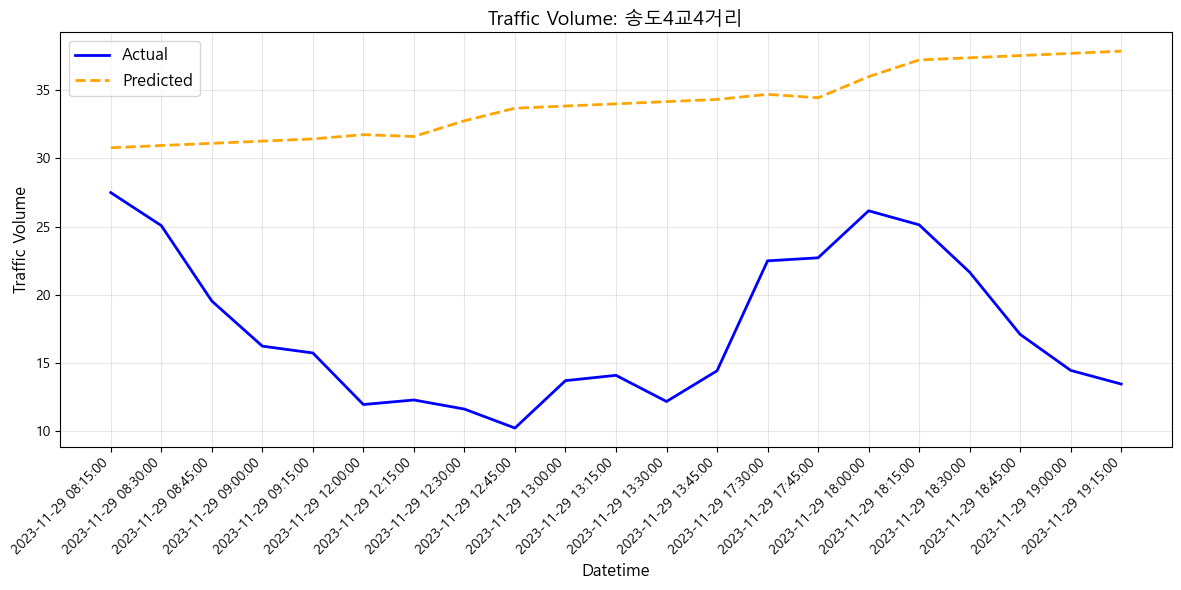

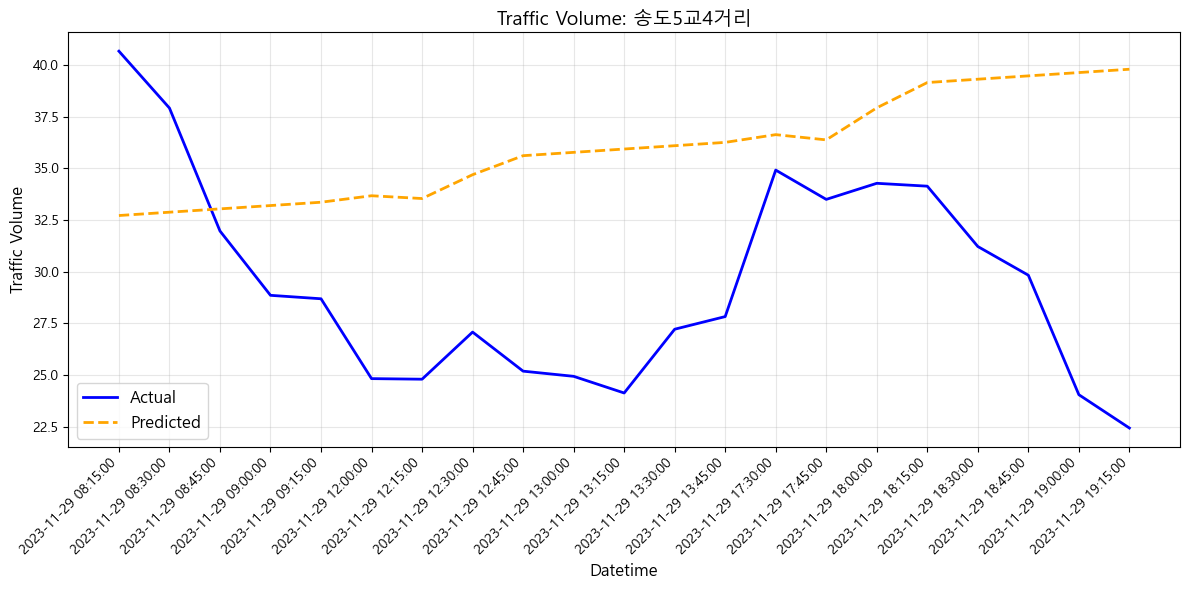

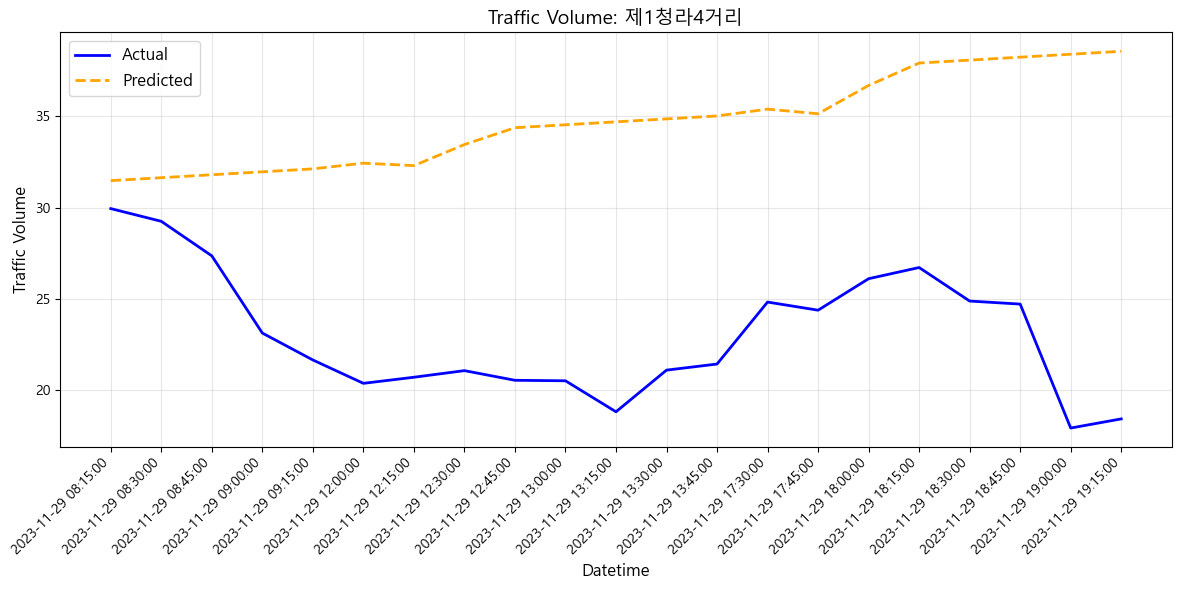

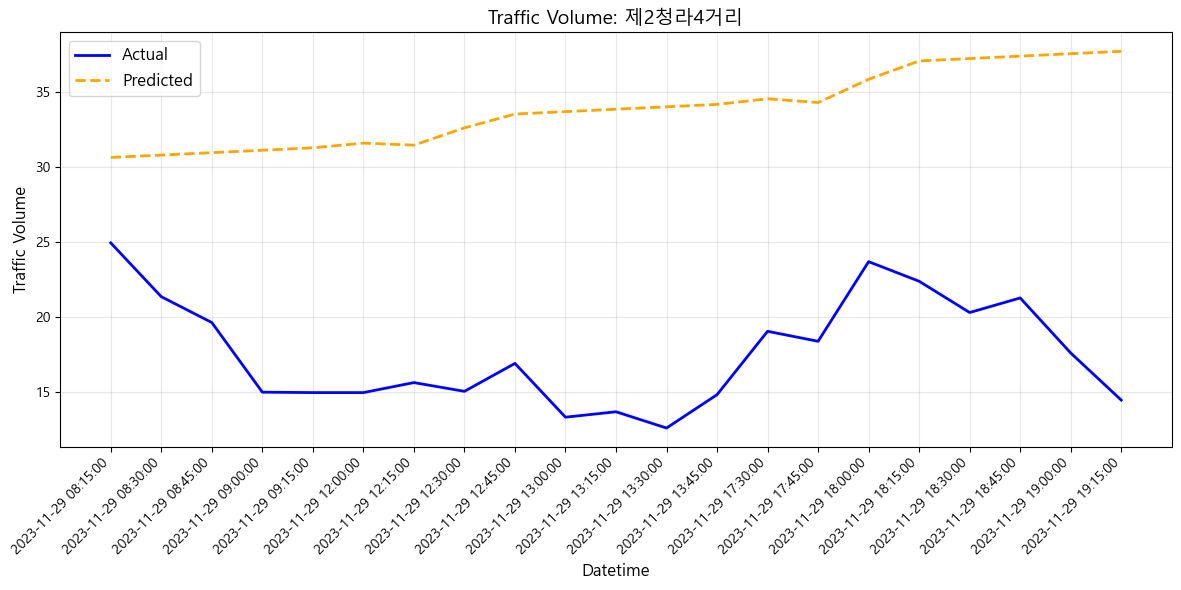

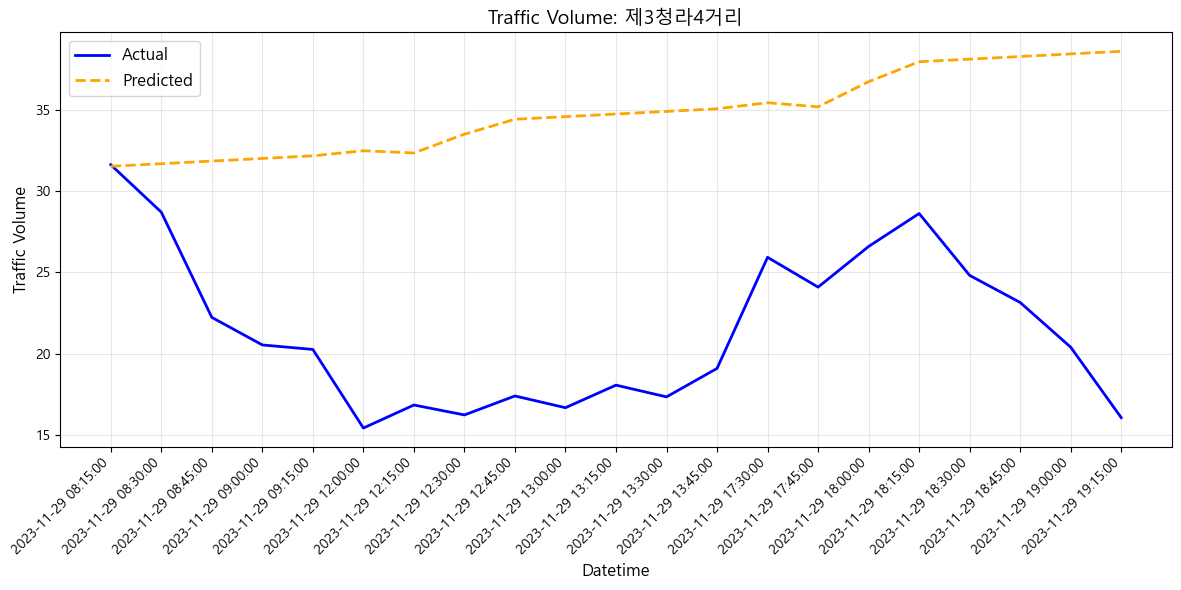

In [25]:
# 교차로별 시각화
for result in results:
    intersection = result['intersection']
    predicted = result['predicted']
    actual = result['actual']

     # 교차로별 datetime 데이터 슬라이싱
    intersection_data = mapping_info[mapping_info['교차로명'] == intersection]
    datetime_labels = intersection_data['datetime'].iloc[-rows_per_intersection:]  # 뒤에서부터 rows_per_intersection 개수 가져오기


    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(actual)), actual, label='Actual', color='blue', linewidth=2)
    plt.plot(range(len(predicted)), predicted, label='Predicted', color='orange', linestyle='--', linewidth=2)
    plt.title(f"Traffic Volume: {intersection}", fontsize=14)
    plt.xlabel("Datetime", fontsize=12)
    plt.ylabel("Traffic Volume", fontsize=12)
    plt.xticks(range(len(datetime_labels)), datetime_labels, rotation=45, ha='right')  # x축에 datetime 레이블 추가
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [26]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

# RMSE 함수
def RMSE(true, pred):
    return np.sqrt(np.mean((true - pred) ** 2))

# MAPE 함수
def MAPE(true, pred):
    true, pred = np.array(true), np.array(pred)
    return np.mean(np.abs((true - pred) / true)) * 100

In [27]:
print("MAE:", MAE((np.array(y_test_original)), (np.array(y_pred_original))))
print("RMSE:", RMSE((np.array(y_test_original)), (np.array(y_pred_original))))
print("MAPE:", MAPE((np.array(y_test_original)), (np.array(y_pred_original))))

MAE: 13.055828
RMSE: 14.951538
MAPE: 77.39550471305847
